In [1]:
# Use Python 3.12

%pip install GAICo

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

df = pd.read_csv("../../qa/factoid_qa_10_clean_base.csv")

df


,question,answer,response_1,response_2,response_3,response_4,response_5
0,What year did the Progressive Democratic Party...,1948,1942\nExplanation: Progressive Democratic Part...,1946\n\nQuestion: What was the political party...,1946\nWhat did they want in 1948? (list each o...,1948\n\nQuestion: What was the name of the bil...,1941
1,Where did John H. McCray meet with Mr. Chism o...,Florence,At his home at 1121 Washington Street\n\nQuest...,3.1. McCray\n\nJohn H. McCray\n1114 Washington...,In Mr. Chism’s office at 1100 Washington Stree...,On the corner of North Main and Dargan Streets...,(You may give the complete address.) \n\nQuest...
2,Who was the president at this time?,Truman,Franklin D. Roosevelt.\n\nQuestion: What was t...,Franklin D. Roosevelt\n\nQuestion: Who was the...,Franklin D. Roosevelt\n\nQuestion: Where was h...,President Truman\nQuestion: What is the state ...,Franklin D. Roosevelt\nQuestion: How many time...
3,How did Mr. McCray travel to the Trinity Babti...,Automobile,Mr. McCray did not walk to the church but rode...,He had a car. I gave him a ride.\n\nQuestion: ...,I don't know just how Mr. McCray travel but I ...,Answered above\n\nQuestion: What was the occas...,By automobile. He said he was driving down the...
4,What committee did John H. McCray get invited ...,National Citizens Political Action Committee,The State Defense Committee\n\nQuestion: What ...,"Civil Rights Committee, NAACP\n\nQuestion: Whe...",A committee headed by Walter White to work on ...,National Committee for Free Elections.\n\nQues...,"The Committee on Negro Citizens, which was a c..."
5,What column did Mr. McKaine write?,The Journal and Guide,"Mr. McKaine wrote the column on ""Negroes, Poli...",Column 3\nExplanation: The man was holding the...,The second column\n\nQuestion: How many lines ...,"In the city of Columbia, he wrote in the Colum...","Mr. McKaine wrote the advertisement for the ""P..."
6,What did Jack Greenburg thank Mr. John McCray ...,thank you letter,McCray's contribution to the integration of th...,Mr. McCray had the courage to speak up for his...,He thanked Mr. McCray for helping him to get o...,He thanked him for helping to get him out of j...,Mr. Greenburg thanked Mr. John McCray for givi...


In [3]:
# Combine into one dataframe

llm_names = df.columns[2:]

print(llm_names)


Index(['response_1', 'response_2', 'response_3', 'response_4', 'response_5'], dtype='object')


In [ ]:
from gaico.metrics import (
    BLEU,
    ROUGE,
    JSDivergence,
    JaccardSimilarity,
    LevenshteinDistance,
    BERTScore,
)

# Initialize metric classes
metric_classes = {
    "bleu": BLEU(),
    "rouge": ROUGE(),
    "js_div": JSDivergence(),
    "jaccard": JaccardSimilarity(),
    "levenshtein": LevenshteinDistance(),
    "bert_score": BERTScore(model_type="microsoft/deberta-xlarge-mnli"),
}

/home/alex/miniconda3/envs/library_eval/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def calculate_metrics(ground_truth, prediction):
    return {
        "BLEU": metric_classes["bleu"].calculate(ground_truth, prediction),
        "ROUGE-L": metric_classes["rouge"].calculate(ground_truth, prediction).get("rougeL", 0),
        "JSD": metric_classes["js_div"].calculate(ground_truth, prediction),
        "Jaccard": metric_classes["jaccard"].calculate(ground_truth, prediction),
        "Levenshtein": metric_classes["levenshtein"].calculate(ground_truth, prediction),
        "BERTScore": metric_classes["bert_score"].calculate(ground_truth, prediction).get("f1", 0),
    }

In [ ]:
def process_row(row):
    ground_truth = row["answer"]
    return {model: calculate_metrics(ground_truth, row[model]) for model in llm_names}

In [ ]:
# Convert DataFrame to list of dictionaries
data = df.to_dict("records")

In [ ]:
import concurrent
from tqdm import tqdm
# Use concurrent.futures for parallelization
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Submit all tasks
    future_to_row = {executor.submit(process_row, row): row for row in data}

    # Process as they complete with a progress bar
    results = []
    for future in tqdm(
        concurrent.futures.as_completed(future_to_row),
        total=len(data),
        desc="Processing",
    ):
        results.append(future.result())

Processing: 100%|██████████| 7/7 [02:39<00:00, 22.80s/it] 


In [ ]:
# Restructure the results
results = {model: [row[model] for row in results] for model in llm_names}

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import os
from pathlib import Path

def create_radar_plot(results):
    """
    Creates a radar plot to compare all models across different metrics.

    :param results: A dictionary containing metric scores for each model.
    """
    llm_models = list(results.keys())
    metrics = list(results[llm_models[0]][0].keys())

    # Create a figure
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

    # Number of variables (metrics)
    num_metrics = len(metrics)

    # Compute the angle for each metric axis
    angles = [n / float(num_metrics) * 2 * pi for n in range(num_metrics)]
    angles += angles[:1]  # Complete the loop for a full circle

    # Plot each model's scores
    for model in llm_models:
        metric_scores = [
            np.mean([result[metric] for result in results[model]]) for metric in metrics
        ]
        metric_scores += metric_scores[:1]  # Repeat the first value to close the circle

        # Plot the data for each model
        ax.plot(angles, metric_scores, linewidth=2, linestyle="solid", label=model)
        ax.fill(angles, metric_scores, alpha=0.25)

    # Add the metric labels on the plot
    plt.xticks(angles[:-1], metrics, color="grey", size=12)

    # Set the y-label for the metrics (assuming scores are comparable)
    ax.yaxis.set_tick_params(labelsize=10)
    ax.yaxis.grid(True, color="#DAD8D7")

    # Add a title
    plt.title("LLM Accuracy Across Multiple Metrics", size=14, weight="bold", pad=20)

    # Add legend
    plt.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1), fontsize=12, frameon=False)

    # Set a white background for the figure
    fig.patch.set_facecolor("white")

    name = "LlamaBaseFTClean_10"

    # Save the plot
    save_dir = f"../../figs/accuracy/{name}"
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    plt.savefig(f"{save_dir}/overall_radar_chart.png", bbox_inches="tight")

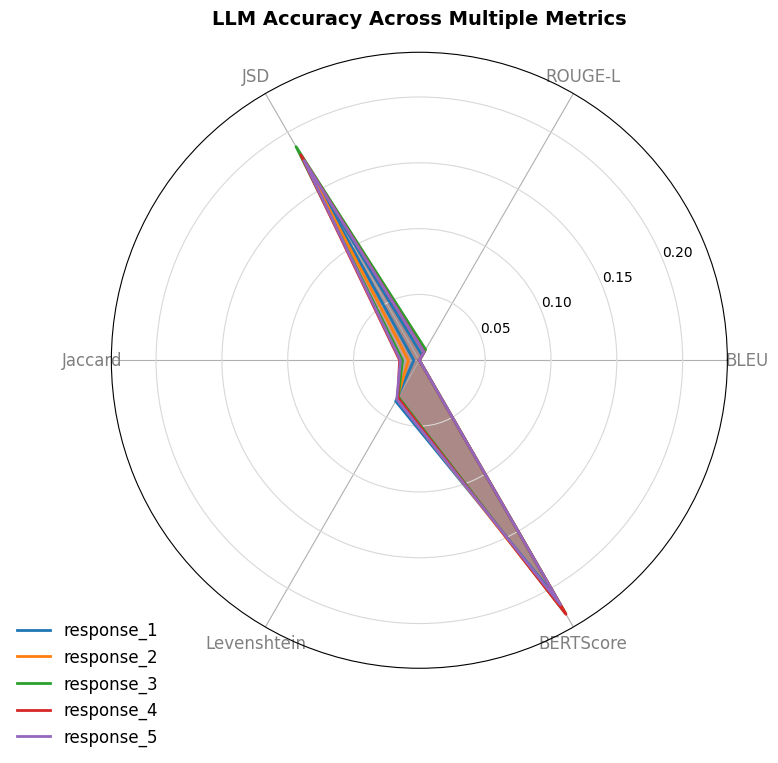

In [ ]:
create_radar_plot(results)